In [10]:
import os
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import cv2

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split


In [11]:
data_dir = r"C:\Dataset_ClassWise"
full_dataset = datasets.ImageFolder(root=data_dir)

print("Classes:", full_dataset.classes)
print("Total images:", len(full_dataset))


Classes: ['looking_down', 'looking_left', 'looking_right', 'looking_straight', 'looking_up', 'multiple_faces']
Total images: 188


In [12]:
targets = full_dataset.targets
indices = list(range(len(full_dataset)))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=42,
    stratify=targets
)

train_dataset = Subset(full_dataset, train_idx)
val_dataset   = Subset(full_dataset, val_idx)

print("Train:", len(train_dataset))
print("Validation:", len(val_dataset))


Train: 150
Validation: 38


In [13]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [14]:
class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        img = self.transform(img)
        return img, label

train_dataset = TransformDataset(train_dataset, train_transform)
val_dataset   = TransformDataset(val_dataset, val_transform)


In [15]:
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
class_sample_count = np.bincount(train_labels)
weights = 1. / class_sample_count
sample_weights = [weights[label] for label in train_labels]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)


In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)
model = model.to(device)

# Train entire model (NO freezing)
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [18]:
class_counts = np.bincount(train_labels)
class_weights = torch.tensor(1. / class_counts, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)


In [19]:
num_epochs = 15
best_val_acc = 0.0

for epoch in range(num_epochs):

    model.train()
    correct = total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs,1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)

    train_acc = correct/total

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = torch.argmax(model(imgs),1)
            correct += (preds==labels).sum().item()
            total += labels.size(0)

    val_acc = correct/total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), r"C:\Dataset_ClassWise\mobilenetv2_best_v2.pth")

    print(f"Epoch {epoch+1}: Train={train_acc:.3f} Val={val_acc:.3f}")

print("Best Val:", best_val_acc)


Epoch 1: Train=0.227 Val=0.184
Epoch 2: Train=0.307 Val=0.105
Epoch 3: Train=0.300 Val=0.132
Epoch 4: Train=0.333 Val=0.132
Epoch 5: Train=0.367 Val=0.211
Epoch 6: Train=0.420 Val=0.316
Epoch 7: Train=0.520 Val=0.474
Epoch 8: Train=0.513 Val=0.474
Epoch 9: Train=0.533 Val=0.421
Epoch 10: Train=0.533 Val=0.447
Epoch 11: Train=0.573 Val=0.579
Epoch 12: Train=0.580 Val=0.579
Epoch 13: Train=0.607 Val=0.605
Epoch 14: Train=0.627 Val=0.632
Epoch 15: Train=0.593 Val=0.579
Best Val: 0.631578947368421


                  precision    recall  f1-score   support

    looking_down       0.75      0.60      0.67        10
    looking_left       0.31      0.80      0.44         5
   looking_right       0.50      0.33      0.40         6
looking_straight       0.33      0.20      0.25         5
      looking_up       0.88      0.70      0.78        10
  multiple_faces       1.00      1.00      1.00         2

        accuracy                           0.58        38
       macro avg       0.63      0.61      0.59        38
    weighted avg       0.64      0.58      0.59        38



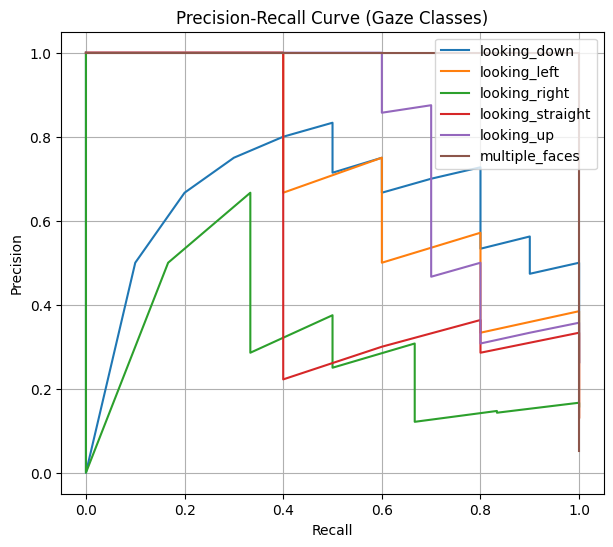

In [20]:
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)

        preds = torch.argmax(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

# ========================
# Classification Report
# ========================
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

# ========================
# Precision-Recall Curve (One vs Rest)
# ========================
labels_bin = label_binarize(all_labels, classes=range(len(full_dataset.classes)))

plt.figure(figsize=(7,6))

for i, class_name in enumerate(full_dataset.classes):
    precision, recall, _ = precision_recall_curve(labels_bin[:, i],
                                                  np.array(all_probs)[:, i])
    plt.plot(recall, precision, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Gaze Classes)")
plt.legend()
plt.grid()
plt.show()


In [21]:
import cv2
import torch
import time
import pandas as pd
from PIL import Image
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = ['looking_down','looking_left','looking_right',
           'looking_straight','looking_up','multiple_faces']

# Load trained model
model = models.mobilenet_v2(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(classes))
model.load_state_dict(torch.load(r"C:\Dataset_ClassWise\mobilenetv2_clean_best.pth", map_location=device))
model = model.to(device)
model.eval()

face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

MAX_CHANCES = 3
MAX_CONTINUOUS = 4.0

start_time = time.time()
violation_count = 0
continuous_start = None
log = []

cap = cv2.VideoCapture(0)

print("Monitoring started...")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    t = time.time() - start_time
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray,1.3,5)

    gaze = "no_face"
    if len(faces)==0:
        gaze="no_face"
    elif len(faces)>1:
        gaze="multiple_faces"
    else:
        x,y,w,h = faces[0]
        crop = frame[y:y+h,x:x+w]
        img = Image.fromarray(cv2.cvtColor(crop,cv2.COLOR_BGR2RGB))
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            gaze = classes[torch.argmax(model(img),1).item()]

    if gaze!="looking_straight":
        if continuous_start is None:
            continuous_start = t
        away = t - continuous_start
        reason="Looking Away"
    else:
        away=0
        continuous_start=None
        reason="Normal"

    if away>MAX_CONTINUOUS:
        violation_count+=1
        continuous_start=None
        reason="Exceeded 4s"

    log.append([round(t,2),gaze,round(away,2),violation_count,reason])

    cv2.putText(frame,f"Gaze: {gaze}",(10,30),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,255,0),2)
    cv2.putText(frame,f"Violations: {violation_count}/3",(10,60),cv2.FONT_HERSHEY_SIMPLEX,0.8,(0,0,255),2)

    cv2.imshow("AI Proctor",frame)

    if violation_count>=MAX_CHANCES:
        print("Cheating detected!")
        break

    if cv2.waitKey(1)&0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

df = pd.DataFrame(log,columns=["Time","Gaze","ContinuousAway","Violations","Reason"])
df.to_csv(r"C:\Dataset_ClassWise\exam_log.csv",index=False)

print("Log saved successfully!")


Monitoring started...
Cheating detected!
Log saved successfully!
